In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Method 1

In [2]:
os.chdir('/Users/elliotbarlow/Desktop/dissertation/Methodology')

/var/folders/sb/_0__cw417s36bj7lz8trtm900000gn/T/ipykernel_12100/4121585417.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data3.append(int(i))


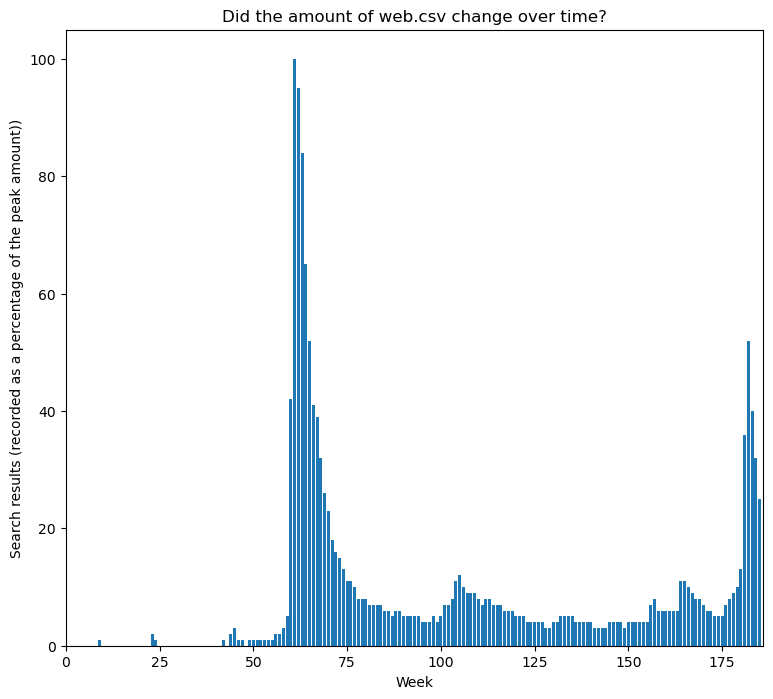

/var/folders/sb/_0__cw417s36bj7lz8trtm900000gn/T/ipykernel_12100/4121585417.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data3.append(int(i))


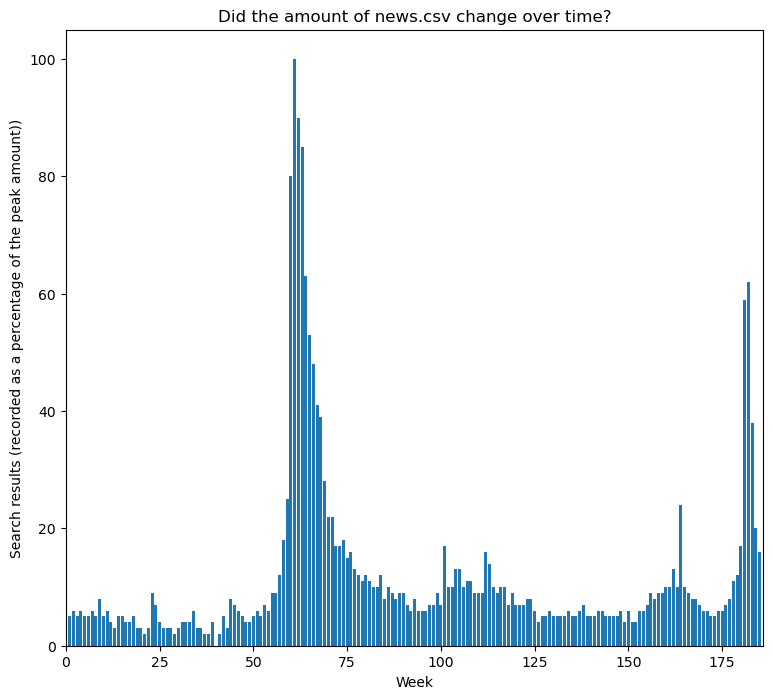

/var/folders/sb/_0__cw417s36bj7lz8trtm900000gn/T/ipykernel_12100/4121585417.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data3.append(int(i))


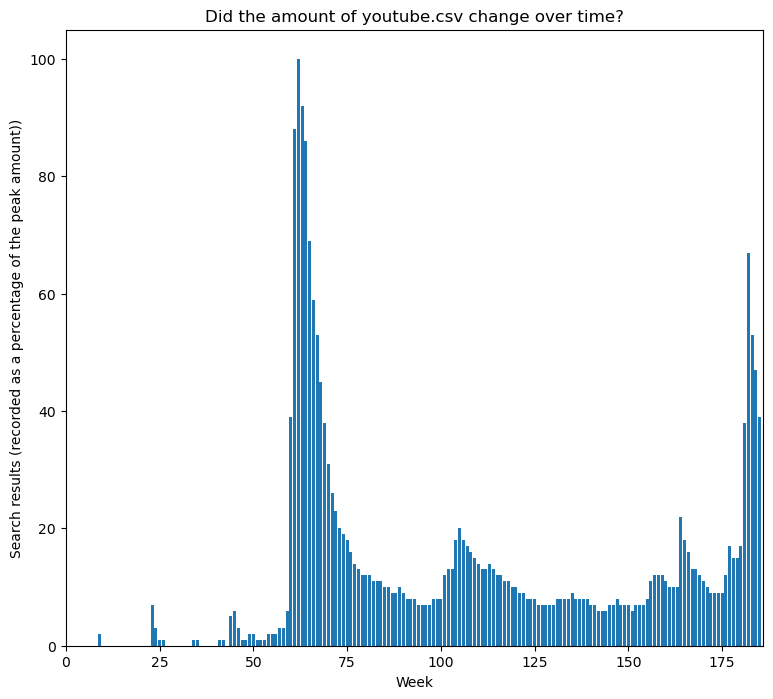

In [3]:
def searchresultbarchartplotter(file):
    """Plots a barchart of the frequency of seach results for the type of internet search."""
    data = pd.read_csv(file)
    
    data2 = data.replace('<1',0).values[1:]
    data3=[]
    for i in data2:
        data3.append(int(i))
    values =np.array(data3) #count_data
    weeks = len(values) #n_count_data in the book
    
    plt.rcParams['figure.figsize'] = [9, 8]
    plt.bar(np.arange(weeks), np.array(values))
    plt.xlabel("Week")
    plt.ylabel("Search results (recorded as a percentage of the peak amount))")
    plt.title(f"Did the amount of {file} change over time?")
    plt.xlim(0, weeks);
    plt.show()
for i in ['web.csv', 'news.csv', 'youtube.csv']:
    searchresultbarchartplotter(i)

In [4]:
import pymc as pm

/var/folders/sb/_0__cw417s36bj7lz8trtm900000gn/T/ipykernel_12100/3709142100.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data3.append(int(i))
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [lambda_1]
>Metropolis: [lambda_2]
>Metropolis: [lambda_3]
>Metropolis: [lambda_4]
>Metropolis: [tau_2]
>Metropolis: [tau]
>Metropolis: [tau_3]
>Metropolis: [alpha_nb]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 13 seconds.


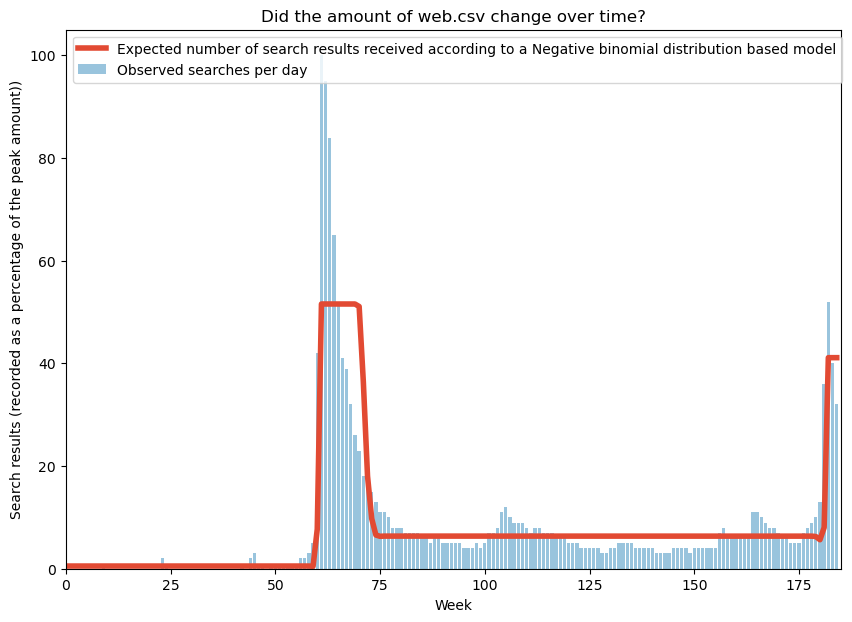

The MSE is: 58.180355516012646


In [5]:
os.chdir('/Users/elliotbarlow/Desktop/dissertation/Methodology')
def changefinder(file, oberservation_type, startweek = 0, endweek = -1):
    if file is None:
        data2 = [50]*100 +[25]*100 + [75]*100 +[100]*100
        data2 = [50]*100
    else:
        data = pd.read_csv(file)
    
        data2 = data.replace('<1',0.5).values[1:]
    data3 = []
    
    for i in data2[startweek : endweek]:
        data3.append(int(i))
        
    values = np.array(data3) #count_data in the book
    weeks = len(values) #n_count_data in the book
    alpha = 1.0 / weeks
    
    with pm.Model() as model:
        #Period one: 0-Tau: lambda_1
        lambda_1 = pm.Exponential("lambda_1", alpha)
        #Period two: Tau-Tau_2: lambda_2
        lambda_2 = pm.Exponential("lambda_2", alpha)
        #Period three: Tau_2-Tau_3: lambda_3
        lambda_3 = pm.Exponential("lambda_3", alpha)
        #Period four: Tau_3-End: lambda_4
        lambda_4 = pm.Exponential("lambda_4", alpha)

        tau_2 = pm.DiscreteUniform("tau_2", lower = 0, upper = weeks)
        tau = pm.DiscreteUniform("tau", lower = 0, upper = tau_2)
        tau_3 = pm.DiscreteUniform("tau_3", lower = tau_2, upper = weeks)

        idx = np.arange(weeks) # Index
        lambda_ = pm.math.switch(idx < tau, lambda_1,
                                 pm.math.switch(idx < tau_2, lambda_2, 
                                                pm.math.switch(idx < tau_3, lambda_3, lambda_4))) 
        
        
        if oberservation_type == "Poisson distribution":
            observation = pm.Poisson("obs", lambda_, observed = values)
            
        if oberservation_type == "Negative binomial distribution":
            alpha_nb = pm.Exponential("alpha_nb", 0.5)
            observation = pm.NegativeBinomial("obs", mu = lambda_, alpha = alpha_nb, observed = values)
            
        if oberservation_type == "Zero-inflated Poisson":
            psi = pm.Beta("psi", 1/2, 1/2)
            observation = pm.ZeroInflatedPoisson("obs", psi = psi, mu = lambda_, observed = values)
            
        if oberservation_type == "Normal dististribution":
            observation = pm.Normal('obs', mu = lambda_, observed = values) 
            
        #fix and check    
        if oberservation_type == "Binomial distribution":
            #Period one: 0-Tau: P_1
            P_1 = pm.Uniform("P_1", 0,1)
            #Period two: Tau-Tau_2: P_2
            P_2 = pm.Uniform("P_2", 0,1)
            #Period three: Tau_2-Tau_3: P_3
            P_3 = pm.Uniform("P_3", 0,1)
            #Period four: Tau_3-End: P_4
            P_4 = pm.Uniform("P_4", 0,1)
            
            P_ = pm.math.switch(idx < tau, P_1,
                         pm.math.switch(idx < tau_2, P_2, 
                                        pm.math.switch(idx < tau_3, P_3, P_4))) 
            
            observation = pm.Binomial('obs', n = np.max(values), p = P_, observed = values) #fix
            
        if oberservation_type == "T Student distribution":
            # sigma = , lam = , (other possible parameters)
            pm.StudentT('obs', nu = 100, mu = lambda_, observed = values)

        step = pm.Metropolis()
        trace = pm.sample(10000, tune = 5000, step = step, return_inferencedata = False)
        
    lambda_1_samples = trace['lambda_1']
    lambda_2_samples = trace['lambda_2']
    lambda_3_samples = trace['lambda_3']
    lambda_4_samples = trace['lambda_4']
    
    if oberservation_type == "Binomial distribution":
        P_1_sample = trace['P_1']
        P_2_sample = trace['P_2']
        P_3_sample = trace['P_3']
        P_4_sample = trace['P_4']
    
    tau_samples = trace['tau']
    tau_2_samples = trace['tau_2']
    tau_3_samples = trace['tau_3']

    N = tau_samples.shape[0]
    expected_texts_per_day = np.zeros(weeks)
    for day in range(0, weeks):
        ix_1 = day < tau_samples
        
        ix2_upperbound = (day < tau_2_samples)
        ix2_lowerbound = (day > tau_samples)
        ix_2 = np.logical_and(ix2_upperbound, ix2_lowerbound)

        ix3_upperbound = (day < tau_3_samples)
        ix3_lowerbound = (day > tau_2_samples)
        ix_3 = np.logical_and(ix3_upperbound, ix3_lowerbound)

        ix_4 = day > tau_3_samples
        
        if oberservation_type == "Binomial distribution":
            expected_texts_per_day[day] = 100*(P_1_sample[ix_1].sum()
                                   + P_2_sample[ix_2].sum()
                                  +  P_3_sample[ix_3].sum()
                                  + P_4_sample[ix_4].sum()) / N
        else:
            expected_texts_per_day[day] = (lambda_1_samples[ix_1].sum()
                                           + lambda_2_samples[ix_2].sum()
                                          + lambda_3_samples[ix_3].sum()
                                          + lambda_4_samples[ix_4].sum()) / N
    
    plt.rcParams['figure.figsize'] = [10, 7]
    plt.plot(range(weeks), expected_texts_per_day, color="#E24A33", lw=4,
             label = f"Expected number of search results received according to a {oberservation_type} based model")
    
    if endweek == -1:
        plt.xlim(startweek, weeks)
    else:
        plt.xlim(startweek, endweek)
    plt.bar(np.arange(weeks), values, color="#348ABD", alpha=0.5,
            label="Observed searches per day")
    name = file
    plt.xlabel("Week")
    plt.ylabel("Search results (recorded as a percentage of the peak amount))")
    plt.title(f"Did the amount of {file} change over time?")
    
    plt.legend(loc="upper left")
    #plt.savefig("/Desktop/dissertation/Elden Ring stuff", transparent=None, dpi='figure', format="jpeg")
    plt.show()
    
    differences = ( np.array(expected_texts_per_day) - np.array(values) )**2
    MSE = ( sum(differences)/len(values) )
    print('The MSE is:', MSE)

changefinder('web.csv', "Negative binomial distribution", 0,)

# Compiling results

### You don't need to run the following codes as it will take too long and the results are already provided

distributionlist = ["Poisson distribution", "Negative binomial distribution", "Zero-inflated Poisson", "Normal dististribution", "Binomial distribution",
                    "T Student distribution"]

all_game_model_stats = []
for year in [2022, 2023]: 
    os.chdir(f'/Users/elliotbarlow/Desktop/dissertation/data/{year}')
    directlist = [d.name for d in os.scandir() if d.is_dir() and d != '.DS_Store']
    for game in directlist:
        os.chdir(f'/Users/elliotbarlow/Desktop/dissertation/data/{year}/')
        print(game)
        os.chdir(f'/Users/elliotbarlow/Desktop/dissertation/data/{year}/{game}')
        
        potentialfilenames = os.listdir()
        filenames = []
        for potentialfile in potentialfilenames:
            if potentialfile in ['news searches.csv', 'youtube searches.csv', 'web searches.csv']:
                filenames.append(potentialfile)         
            
        print(filenames)
        game_model_stats_stats = []
        for file in filenames:
            print(file)
            for dist in distributionlist:
                print(dist)
                oberservation_type = dist
                
                data = pd.read_csv(file) #, encoding='unicode_escape')
                data2 = data.replace('<1',0.5).values[1:]
                data3 = []
                for i in data2[0 : -1]:
                    data3.append(int(i))
                    
                values = np.array(data3) 
                weeks = len(values) 
                alpha = 1.0 / weeks
                
                with pm.Model() as model:
                    #Period one: 0-Tau: lambda_1
                    lambda_1 = pm.Exponential("lambda_1", alpha)
                    #Period two: Tau-Tau_2: lambda_2
                    lambda_2 = pm.Exponential("lambda_2", alpha)
                    #Period three: Tau_2-Tau_3: lambda_3
                    lambda_3 = pm.Exponential("lambda_3", alpha)
                    #Period four: Tau_3-End: lambda_4
                    lambda_4 = pm.Exponential("lambda_4", alpha)
            
                    tau_2 = pm.DiscreteUniform("tau_2", lower = 0, upper = weeks)
                    tau = pm.DiscreteUniform("tau", lower = 0, upper = tau_2)
                    tau_3 = pm.DiscreteUniform("tau_3", lower = tau_2, upper = weeks)
            
                    idx = np.arange(weeks) # Index
                    lambda_ = pm.math.switch(idx < tau, lambda_1,
                                             pm.math.switch(idx < tau_2, lambda_2, 
                                                            pm.math.switch(idx < tau_3, lambda_3, lambda_4))) 
                    
                    
                    if oberservation_type == "Poisson distribution":
                        observation = pm.Poisson("obs", lambda_, observed = values)
                        
                    if oberservation_type == "Negative binomial distribution":
                        alpha_nb = pm.Exponential("alpha_nb", 0.5)
                        observation = pm.NegativeBinomial("obs", mu = lambda_, alpha = alpha_nb, observed = values)
                        
                    if oberservation_type == "Zero-inflated Poisson":
                        psi = pm.Beta("psi", 1/2, 1/2)
                        observation = pm.ZeroInflatedPoisson("obs", psi = psi, mu = lambda_, observed = values)
                        
                    if oberservation_type == "Normal dististribution":
                        observation = pm.Normal('obs', mu = lambda_, observed = values) 
    
                    #fix and check    
                    if oberservation_type == "Binomial distribution":
                        #Period one: 0-Tau: P_1
                        P_1 = pm.Uniform("P_1", 0,1)
                        #Period two: Tau-Tau_2: P_2
                        P_2 = pm.Uniform("P_2", 0,1)
                        #Period three: Tau_2-Tau_3: P_3
                        P_3 = pm.Uniform("P_3", 0,1)
                        #Period four: Tau_3-End: P_4
                        P_4 = pm.Uniform("P_4", 0,1)
                        
                        P_ = pm.math.switch(idx < tau, P_1,
                                     pm.math.switch(idx < tau_2, P_2, 
                                                    pm.math.switch(idx < tau_3, P_3, P_4))) 
                        
                        observation = pm.Binomial('obs', n = np.max(values), p = P_, observed = values) #fix
                        
                    if oberservation_type == "T Student distribution":
                        # sigma = , lam = other parameters
                        pm.StudentT('obs', nu = 100, mu = lambda_, observed = values)
    
                    step = pm.Metropolis()
                    trace = pm.sample(10000, tune = 5000, step = step, return_inferencedata = False)
                    
                lambda_1_samples = trace['lambda_1']
                lambda_2_samples = trace['lambda_2']
                lambda_3_samples = trace['lambda_3']
                lambda_4_samples = trace['lambda_4']
                
                if oberservation_type == "Binomial distribution":
                    P_1_sample = trace['P_1']
                    P_2_sample = trace['P_2']
                    P_3_sample = trace['P_3']
                    P_4_sample = trace['P_4']
                
                tau_samples = trace['tau']
                tau_2_samples = trace['tau_2']
                tau_3_samples = trace['tau_3']
                
                N = tau_samples.shape[0]
                expected_texts_per_day = np.zeros(weeks)
                for day in range(0, weeks):
                    ix_1 = day < tau_samples
                    
                    ix2_upperbound = (day < tau_2_samples)
                    ix2_lowerbound = (day > tau_samples)
                    ix_2 = np.logical_and(ix2_upperbound, ix2_lowerbound)
            
                    ix3_upperbound = (day < tau_3_samples)
                    ix3_lowerbound = (day > tau_2_samples)
                    ix_3 = np.logical_and(ix3_upperbound, ix3_lowerbound)
            
                    ix_4 = day > tau_3_samples
                    
                    if oberservation_type == "Binomial distribution":
                        expected_texts_per_day[day] = 100*(P_1_sample[ix_1].sum()
                                               + P_2_sample[ix_2].sum()
                                              +  P_3_sample[ix_3].sum()
                                              + P_4_sample[ix_4].sum()) / N
                    else:
                        expected_texts_per_day[day] = (lambda_1_samples[ix_1].sum()
                                                       + lambda_2_samples[ix_2].sum()
                                                      + lambda_3_samples[ix_3].sum()
                                                      + lambda_4_samples[ix_4].sum()) / N
                        
                    
                differences = ( np.array(expected_texts_per_day) - np.array(values) )**2
                MSE = ( sum(differences)/len(values) )
                all_game_model_stats.append( [year, game, file, dist, MSE, values, expected_texts_per_day] )
                
            #game_model_stats_stats.append( [file, model_stats] )
        #all_game_model_stats.append( [game, game_model_stats_stats] ) 

len(all_game_model_stats)= 1458

# Don't re-run this next cell once run!!!!!!!!!!

os.chdir('/Users/elliotbarlow/Desktop/dissertation/')
import pickle
with open("results for method 1.obj", "wb") as filehandler: #Don't re-run
    pickle.dump(all_game_model_stats, filehandler)


# Run this to open the results

In [6]:
os.chdir('/Users/elliotbarlow/Desktop/dissertation/')
with open("results for method 1.obj", "rb") as filehandler:
    results_table = pickle.load(filehandler)

NameError: name 'pickle' is not defined

In [ ]:
results_table